## import required libraries to run model

In [0]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras import regularizers
from keras.models import Sequential ,load_model
from keras.layers.convolutional import Convolution2D, MaxPooling2D,AveragePooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import Callback ,ReduceLROnPlateau ,ModelCheckpoint
import os
from keras import optimizers

# Load cifar data to print first 10 classes

In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_rows, img_cols,img_channels =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

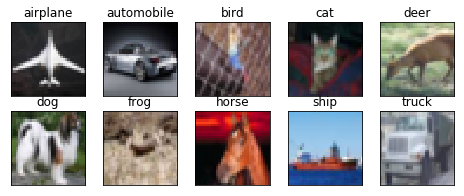

In [6]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

# Test and train data sets loading with Normalization

In [7]:
# load dataset
(trainX, trainy), (testX, testy) = cifar10.load_data()


print('Statistics train=%.3f (%.3f), test=%.3f (%.3f)' % (trainX.mean(), trainX.std(), testX.mean(), testX.std()))

# create generator that centers pixel values
datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)

# calculate the mean on the training dataset
datagen.fit(trainX)
#print('Data Generator mean=%.3f, std=%.3f' % (datagen.mean, datagen.std))

# demonstrate effect on a single batch of samples
iterator_train = datagen.flow(trainX, trainy, batch_size=128)

# get a batch
batchX, batchy = iterator_train.next()

# pixel stats in the batch
print(batchX.shape, batchX.mean(), batchX.std())

# demonstrate effect on entire training dataset
iterator_train = datagen.flow(trainX, trainy, batch_size=len(trainX), shuffle=False)

# get a batch
batchX, batchy = iterator_train.next()

# pixel stats in the batch
print(batchX.shape, batchX.mean(), batchX.std())

Statistics train=120.708 (64.150), test=121.529 (64.061)
(128, 32, 32, 3) 0.01989002 1.0052702
(50000, 32, 32, 3) -1.6605131e-06 1.0000001


In [0]:
iterator_test = datagen.flow(testX, testy, batch_size=len(testX), shuffle=False)
batch_testX, batch_testy = iterator_test.next()

X_train = batchX
X_test = batch_testX

y_train=batchy
y_test=batch_testy
                        

In [0]:
# Convert 1-dimensional class arrays to 10-dimensional class matrices
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)

# MODEL and summary

In [0]:
# Define the model

def create_Base_Model():
  
  model1 = Sequential()
  model1.add(Convolution2D(32, 3, 3, border_mode='same',kernel_regularizer=regularizers.l2(0.0001), input_shape=(32, 32, 3)))
  model1.add(Activation('relu'))
  model1.add(BatchNormalization())

  model1.add(Convolution2D(64, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same'))
  model1.add(Activation('relu'))
  model1.add(BatchNormalization())

  model1.add(MaxPooling2D(pool_size=(2, 2)))
  model1.add(Dropout(0.2))

  model1.add(Convolution2D(32, 1, 1))


  model1.add(Convolution2D(64, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same'))
  model1.add(Activation('relu'))
  model1.add(BatchNormalization())

  model1.add(Convolution2D(128, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same'))
  model1.add(Activation('relu'))
  model1.add(BatchNormalization())

  model1.add(MaxPooling2D(pool_size=(2, 2)))
  model1.add(Dropout(0.3))

  model1.add(Convolution2D(32, 1, 1))


  model1.add(Convolution2D(128, 3, 3,kernel_regularizer=regularizers.l2(0.0001), border_mode='same'))
  model1.add(Activation('relu'))
  model1.add(BatchNormalization())

  model1.add(Convolution2D(256, 3, 3,kernel_regularizer=regularizers.l2(0.0001), border_mode='same'))
  model1.add(Activation('relu'))
  model1.add(BatchNormalization())

  model1.add(MaxPooling2D(pool_size=(2, 2)))
  model1.add(Dropout(0.5))

  model1.add(Convolution2D(10, 1, 1))

  model1.add(AveragePooling2D(pool_size = (4,4)))
  model1.add(Flatten())


  model1.add(Activation('softmax'))


  return model1


In [117]:
# Compile the model
model1 = create_Base_Model()
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model1.summary()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), kernel_regularizer=<keras.reg..., input_shape=(32, 32, 3..., padding="same")`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), kernel_regularizer=<keras.reg..., padding="same")`
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (1, 1))`
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), kernel_regularizer=<keras.reg..., padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), kernel_regularizer=<keras.reg..., pad

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_91 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_71 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_61 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_92 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
activation_72 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_62 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 16, 16, 64)        0         
__________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(10, (1, 1))`


### hyper parametres

In [0]:
bs = 64
num_classes = 10
epochs = 5

# LR finder 

In [0]:
class LR_Finder(Callback):
    
    def __init__(self, start_lr=1e-5, end_lr=10, step_size=None, beta=.98):
        super().__init__()
        
        self.start_lr = start_lr
        self.end_lr = end_lr
        self.step_size = step_size
        self.beta = beta
        self.lr_mult = (end_lr/start_lr)**(1/step_size)
        
    def on_train_begin(self, logs=None):
        self.best_loss = 1e9
        self.avg_loss = 0
        self.losses, self.smoothed_losses, self.lrs, self.iterations = [], [], [], []
        self.iteration = 0
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.start_lr)
        
    def on_batch_end(self, epoch, logs=None):
        logs = logs or {}
        loss = logs.get('loss')
        self.iteration += 1
        
        self.avg_loss = self.beta * self.avg_loss + (1 - self.beta) * loss
        smoothed_loss = self.avg_loss / (1 - self.beta**self.iteration)
        
        # Check if the loss is not exploding
        if self.iteration>1 and smoothed_loss > self.best_loss * 4:
            self.model.stop_training = True
            return

        if smoothed_loss < self.best_loss or self.iteration==1:
            self.best_loss = smoothed_loss
        
        lr = self.start_lr * (self.lr_mult**self.iteration)
        
        self.losses.append(loss)
        self.smoothed_losses.append(smoothed_loss)
        self.lrs.append(lr)
        self.iterations.append(self.iteration)
        
        
        K.set_value(self.model.optimizer.lr, lr)  
        
    def plot_lr(self):
        plt.xlabel('Iterations')
        plt.ylabel('Learning rate')
        plt.plot(self.iterations, self.lrs)
        
    def plot(self, n_skip=10):
        plt.ylabel('Loss')
        plt.xlabel('Learning rate (log scale)')
        plt.plot(self.lrs[n_skip:-5], self.losses[n_skip:-5])
        plt.xscale('log')
        
    def plot_smoothed_loss(self, n_skip=10):
        plt.ylabel('Smoothed Losses')
        plt.xlabel('Learning rate (log scale)')
        plt.plot(self.lrs[n_skip:-5], self.smoothed_losses[n_skip:-5])
        plt.xscale('log')
        
    def plot_loss(self):
        plt.ylabel('Losses')
        plt.xlabel('Iterations')
        plt.plot(self.iterations[10:], self.losses[10:])

In [0]:
lr_finder = LR_Finder(start_lr=1e-5, end_lr=10, step_size=np.ceil(X_train.shape[0]/bs))

In [121]:
print(train_features.shape[0])

50000


# Cut out

In [0]:
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

# model.FIT and LR finder plots


In [123]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False, preprocessing_function=get_random_eraser(v_l=0, v_h=1, pixel_level=True))


# train the model
start = time.time()
# Train the model
model_info = model1.fit_generator(datagen.flow(X_train, Y_train, batch_size = bs),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 1,
                                 verbose=1, callbacks=[lr_finder])
end = time.time()
print ("\n Model took %0.2f seconds to train"%(end - start))
# plot model history
# plot_model_history(model_info)
# compute test accuracy
# print ("Accuracy on test data is: %0.2f"%accuracy(X_test, Y_test, model1))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., verbose=1, callbacks=[<__main__..., steps_per_epoch=781, epochs=1)`
  if sys.path[0] == '':


Epoch 1/1
626/781 [=======================>......] - ETA: 3s - loss: 2.5811 - acc: 0.2990
 Model took 18.00 seconds to train


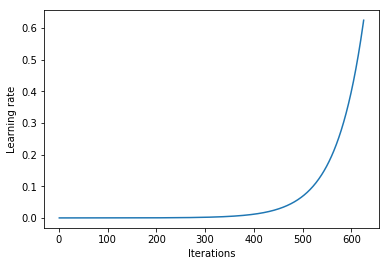

In [124]:
lr_finder.plot_lr()

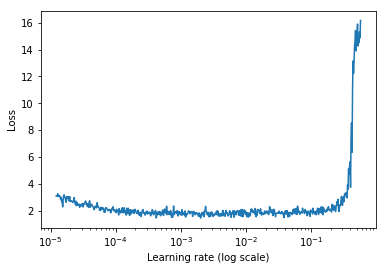

In [125]:
lr_finder.plot()

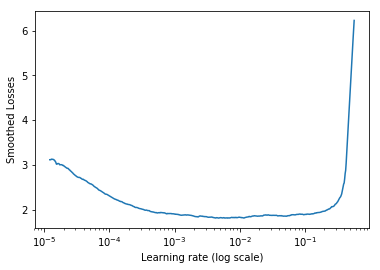

In [126]:
lr_finder.plot_smoothed_loss()

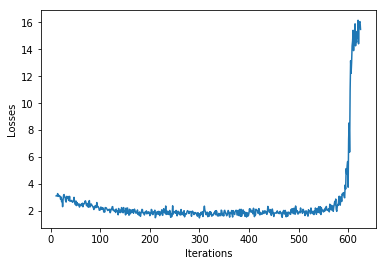

In [127]:
lr_finder.plot_loss()

### Based on above plot the good LR is  0.01

In [128]:
model_SDG = create_Base_Model()

best_LR = 0.01

sgd = optimizers.SGD(lr=best_LR, decay=1e-6, momentum=0.9, nesterov=True)
model_SDG.compile(sgd,loss='categorical_crossentropy', metrics=['accuracy'])


reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.8,patience=5, min_lr=0.1e-8,verbose = 1)
# model.fit(X_train, Y_train, callbacks=[reduce_lr])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), kernel_regularizer=<keras.reg..., input_shape=(32, 32, 3..., padding="same")`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), kernel_regularizer=<keras.reg..., padding="same")`
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (1, 1))`
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), kernel_regularizer=<keras.reg..., padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), kernel_regularizer=<keras.reg..., pad

In [11]:
from google.colab import drive
drive.mount('/content/drive')



# model = load_model('/content/drive/My Drive/EVA_Phase1/BestModel_6A_For_9B.hdf5')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
checkpoint = ModelCheckpoint(filepath='../content/drive/My Drive/EVA_Phase1/model_for_session11.h5', monitor='val_acc', mode='auto', verbose = 1, save_best_only=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=0, callbacks=[<keras.ca..., steps_per_epoch=390, epochs=100)`
  """



Epoch 00001: val_acc improved from -inf to 0.59900, saving model to ../content/drive/My Drive/EVA_Phase1/model_for_session11.h5

Epoch 00002: val_acc improved from 0.59900 to 0.66670, saving model to ../content/drive/My Drive/EVA_Phase1/model_for_session11.h5

Epoch 00003: val_acc improved from 0.66670 to 0.70240, saving model to ../content/drive/My Drive/EVA_Phase1/model_for_session11.h5

Epoch 00004: val_acc improved from 0.70240 to 0.72020, saving model to ../content/drive/My Drive/EVA_Phase1/model_for_session11.h5

Epoch 00005: val_acc improved from 0.72020 to 0.75070, saving model to ../content/drive/My Drive/EVA_Phase1/model_for_session11.h5

Epoch 00006: val_acc improved from 0.75070 to 0.75840, saving model to ../content/drive/My Drive/EVA_Phase1/model_for_session11.h5

Epoch 00007: val_acc improved from 0.75840 to 0.77710, saving model to ../content/drive/My Drive/EVA_Phase1/model_for_session11.h5

Epoch 00008: val_acc improved from 0.77710 to 0.78800, saving model to ../cont

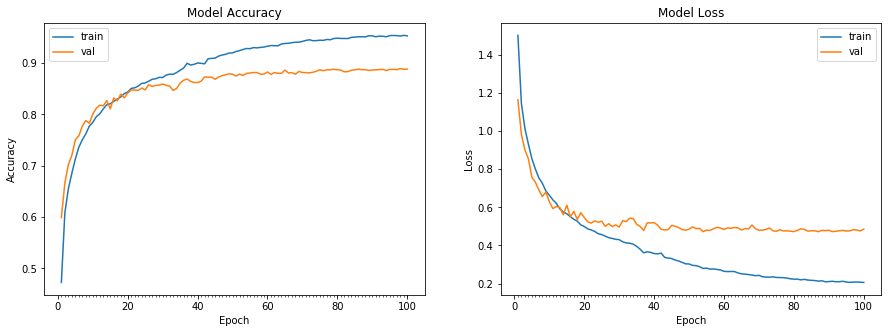

Accuracy on test data is: 88.85


In [131]:
# train the model
start = time.time()
# Train the model
model_info = model_SDG.fit_generator(datagen.flow(X_train, Y_train, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 100, 
                                 validation_data = (X_test, Y_test),verbose=0 ,callbacks=[checkpoint, reduce_lr])
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(X_test, Y_test, model_SDG))

In [0]:
model_saved=load_model('/content/drive/My Drive/EVA_Phase1/model_for_session11.h5')

In [71]:
score = model_saved.evaluate(X_test, Y_test, batch_size=128)
print (score[1])

10000/10000 [==============================] - 2s 174us/step
0.8892


In [0]:
Y_pred = model_saved.predict(X_test)

# Missclassified images and GradCam 

In [0]:
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.gridspec as gridspec
import math
import matplotlib.gridspec as gridspec
from keras.preprocessing import image
import sklearn
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import pandas as pd

### loaded saved model and finding second last conv layer to apply gradcam

In [81]:
lastLayer = model_saved.layers[-9]
print(lastLayer.name)

conv2d_107


In [82]:
matrix = metrics.confusion_matrix(Y_test.argmax(axis=1), Y_pred.argmax(axis=1))
print(matrix)

[[906   8  20   4   9   3   3   4  29  14]
 [  9 948   1   1   1   0   3   1   9  27]
 [ 26   1 844  23  37  22  34   9   3   1]
 [ 11   2  42 738  39 113  38   9   6   2]
 [  8   1  28  15 905  13  14  14   2   0]
 [  7   0  22  83  30 825  13  19   0   1]
 [  4   1  23  17  10   7 932   4   2   0]
 [  7   1  20  14  24  18   2 912   0   2]
 [ 24   8   3   2   0   0   2   2 950   9]
 [ 13  30   3   6   0   0   2   0  14 932]]


In [0]:
def decode(datum):
    return np.argmax(datum)
  
ytest = []
ypred = []

for i in range(len(Y_test)):
  ytest.append(decode(Y_test[i]))
  ypred.append(decode(Y_pred[i]))

df = pd.DataFrame()
df['Actual'] = ytest
df['Pred']  =  ypred

In [0]:
misclassifiedImages = df.index[df['Actual']!=df['Pred']].tolist()
import random
misclassifiedImages = random.sample(misclassified, 25)

Image Id: 5650
actual lablel: dog
predicted label :horse


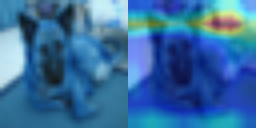

 
Image Id: 8932
actual lablel: frog
predicted label :bird


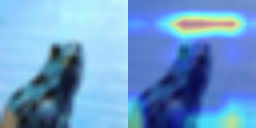

 
Image Id: 128
actual lablel: dog
predicted label :frog


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


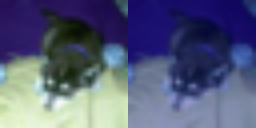

 
Image Id: 5232
actual lablel: cat
predicted label :dog


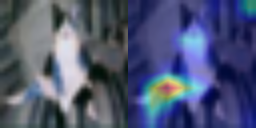

 
Image Id: 1975
actual lablel: frog
predicted label :bird


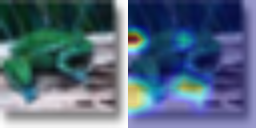

 
Image Id: 7099
actual lablel: cat
predicted label :dog


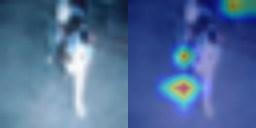

 
Image Id: 751
actual lablel: bird
predicted label :airplane


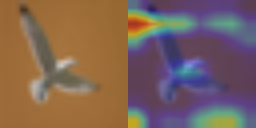

 
Image Id: 6748
actual lablel: airplane
predicted label :bird


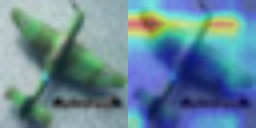

 
Image Id: 1649
actual lablel: dog
predicted label :bird


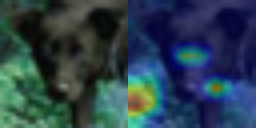

 
Image Id: 6993
actual lablel: dog
predicted label :cat


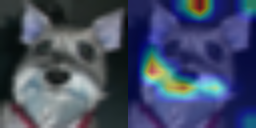

 
Image Id: 7134
actual lablel: deer
predicted label :bird


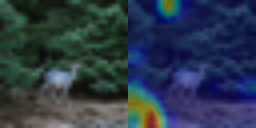

 
Image Id: 8419
actual lablel: horse
predicted label :bird


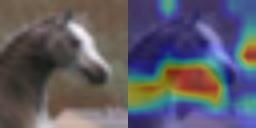

 
Image Id: 1910
actual lablel: deer
predicted label :horse


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


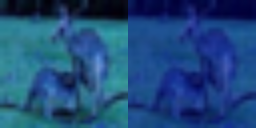

 
Image Id: 2804
actual lablel: cat
predicted label :horse


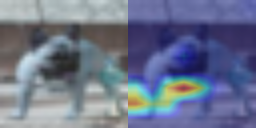

 
Image Id: 836
actual lablel: automobile
predicted label :truck


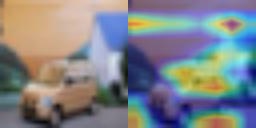

 
Image Id: 8874
actual lablel: horse
predicted label :bird


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


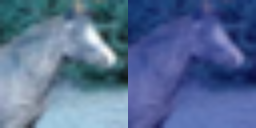

 
Image Id: 8521
actual lablel: truck
predicted label :ship


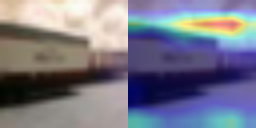

 
Image Id: 1265
actual lablel: truck
predicted label :automobile


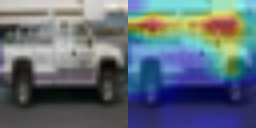

 
Image Id: 5511
actual lablel: cat
predicted label :frog


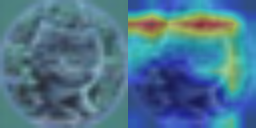

 
Image Id: 4596
actual lablel: horse
predicted label :dog


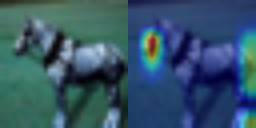

 
Image Id: 9341
actual lablel: bird
predicted label :ship


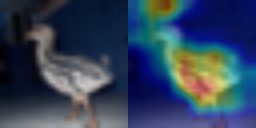

 
Image Id: 6853
actual lablel: deer
predicted label :dog


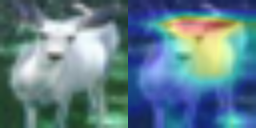

 
Image Id: 5856
actual lablel: cat
predicted label :dog


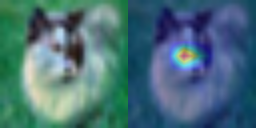

 
Image Id: 5582
actual lablel: deer
predicted label :bird


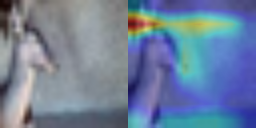

 
Image Id: 7444
actual lablel: truck
predicted label :automobile


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


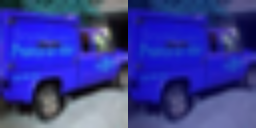

In [85]:
# Missclassified Images - count 25 choosen randomly- apply gradcam
images = misclassifiedImages

for j in images:
  x = testX[j]
  x = np.expand_dims(x, axis=0)
  preds = model.predict(x,batch_size=1)
  class_idx = np.argmax(preds[0])
  class_output = model.output[:, class_idx]
  last_conv_layer = model.get_layer("conv2d_107")

  grads = K.gradients(class_output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([x])
  for i in range(256):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
  
  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap) 
  img = (testX[j])
  img = cv2.resize(img,(128,128))
  heatmap = cv2.resize(heatmap, (128, 128))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
 
  concatimg = cv2.hconcat([img,superimposed_img])
  
  # Display the concatenated image
  print ("Image Id: " + str(j))
  print ("actual lablel: " + str(class_names[df['Actual'][j]]))
  print ("predicted label :" + str(class_names[df['Pred'][j]]))
  cv2_imshow(concatimg)
  cv2.waitKey(0)
  print (" ")
  j = j + 1